# Simulating single-spin dynamics on an IBM-QE

The spin is an internal degree of freedom of the electron that can be manipulated through external magnetic fields.
In particular, for a for a $spin-\frac{1}{2}$ particle we have two distinct states $\vert 0 \rangle$ and $\vert 1 \rangle$. 

In [22]:
%matplotlib inline
from qiskit import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline

Define a function to find the state after 1000 shots.

In [23]:
shots = 1000 

def get_from(d: dict, key: str):

    value = 0
    if key in d:
        value = d[key]
    return value/shots

### Spin precession

Now, as a second application, we discuss the experimental simulation of the Larmor precession phenomenon. Let us
consider that the system is driven by a time-independent magnetic field along z-direction, i.e.

\begin{equation}
    \vec{B}_0 = B_0 \hat{z}
\end{equation}

The algorthm can be structured in 3 steps:

**step 1** - The initial state: As mentioned, the IBM-QE has a natural input state given by $| 0 \rangle$, so any
algorithm input state should be achieved from it. In particular, the initial state $| \psi_0 \rangle$ can be obtained from $| 0 \rangle$ through the unitary operation:

\begin{equation} 
    U_{inp} (t) = e^{- \frac{i \omega t}{2}} \begin{bmatrix}
    cos(\frac{\theta}{2})&-sin(\frac{\theta}{2})\\
    sin(\frac{\theta}{2})&cos(\frac{\theta}{2})\\
    \end{bmatrix}
 \end{equation}

The above unitary operator is obtained from the gate $U_3(\theta, \phi, \lambda)$; if we set $\lambda = 0$, $\phi = 0$. Thus, we have $U_{inp} = U_3(\theta, 0, 0)$.

**step 2** - The evolution: As previously discussed, the evolution as provided by operator $\tilde{U}_0(t)$ can be achieved through the $U_1(\lambda)$ gate (up to a global phase) whenever we set $\lambda = \omega \theta t$.

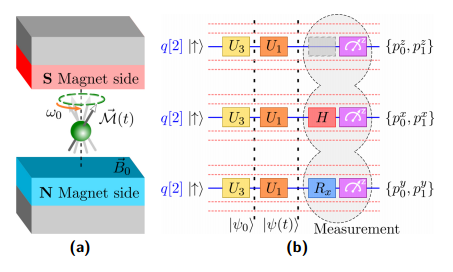


**step 3** - The measurement: The last circuit step is the measurement. To measure the z-spin component we do not need to implement rotations, since the natural measurement basis of the IBM-EQ is the computational basis ("spin-up" and "spin-down" basis in our case). The spin measurement along $x$ and $y$ direction are obtained as discussed in Sec. 2.2, so we need to implement a Hadamard (H) gate and $R_x = R_x^\dagger (−\pi/2)$ gate to measure in x and y basis, respectively.

In [27]:
def probability(measure):
    # Listas para extração de valores das medidas de a² e b²
    pr_0 = [] # lista com os valores de probabilidade de se obter o qubit 0 após 1000 shots
    pr_1 = [] # lista com os valores de probabilidade de se obter o qubit 1 após 1000 shots
    expc = [] # valor esperado: pr_0- pr_1
    T = [] # valores de tempo
    
    # Função em função do tempo
    for t in range(25):
        q = QuantumRegister(1)
        c = ClassicalRegister(1)
        circuit = QuantumCircuit(q, c)         
        
        # Aplicação do Operador U_3 para inicialização do estado no sistema
        circuit.u(np.pi/2, 0, 0, q[0]) # aplicar a porta U_3
        
        # Aplicação do Operador U_0(t)
        circuit.p(t,q[0]) # aplicar a porta U_1: 𝜔 = 1.
        
        
        # Medidas do processo
        if measure == 'Z':
            circuit.measure(q[0], c[0]) 
        elif measure == 'X':
            circuit.h(q[0])
            circuit.measure(q[0], c[0])
        elif measure == 'Y':
            circuit.rx(-np.pi/2, q[0])
            circuit.measure(q[0], c[0])
    
        simulator = Aer.get_backend('qasm_simulator') # quantum computer qasm simulator.

        job = execute(circuit, backend=simulator, shots=shots)
        
        result = job.result()
        counts = result.get_counts()
        
        pr_0.append(get_from(counts, '0'))
        pr_1.append(get_from(counts, '1'))
        expc.append(get_from(counts, '0')- get_from(counts, '1')) # pr_0 - pr_1
        T.append(t)
    return pr_0, pr_1, expc, T


#### Função para eixos do gráfico: 

* x  -> $\omega_{rft} t$
* y  -> $\frac{\hbar}{2} \langle S \rangle$

In [28]:
def smooth_line(axe):
# Using some Matplotlib and Scipy functions to get nice and smooth lines.
    time = np.array(probability('Z')[3])
    x_time_smooth = np.linspace(time.min(),time.max(),125)
    spl = make_interp_spline(time, probability(axe)[2], k=3)
    y_expec_smooth = spl(x_time_smooth)
        
    return x_time_smooth, y_expec_smooth



##### Construção dos Gráficos

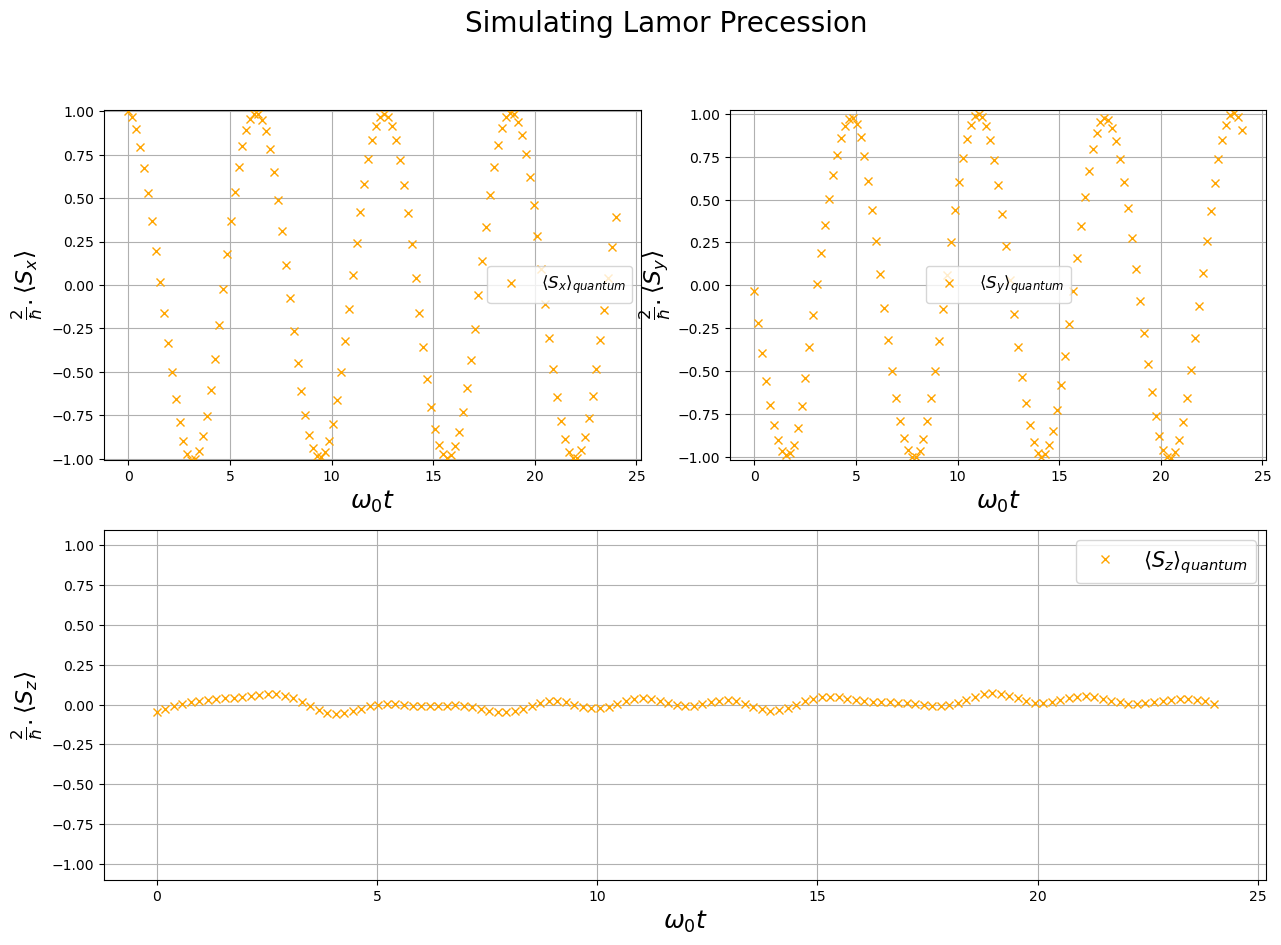

In [29]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 10), gridspec_kw={'wspace': 0.4})
gs = axs[0, 0].get_gridspec()
for ax in axs.ravel():
    ax.remove()
    
fig.suptitle("Simulating Lamor Precession", fontsize=20)
ax1 = fig.add_subplot(gs[0, :2])
###########################<X>############################

ax1.plot(smooth_line('X')[0], smooth_line('X')[1],'x', color='orange'
         , label=r'$\left\langle S_{x} \right\rangle_{quantum}\;$')

ax1.set_xlabel(r'$\omega_0 t$',{'color': 'black', 'fontsize': 18})
ax1.set_ylabel(r'$\frac{2}{\hbar} . \left\langle S_{x} \right\rangle\;$', {'color': 'black', 'fontsize': 17})
ax1.set_ylim(min(smooth_line('X')[1]), max(smooth_line('X')[1]))
ax1.legend(fontsize=12)
ax1.grid(True)

########################<Y>##############################
ax2 = fig.add_subplot(gs[0, 2:])
ax2.plot(smooth_line('Y')[0], smooth_line('Y')[1],'x', color='orange'
         , label=r'$\left\langle S_{y} \right\rangle_{quantum}\;$')

ax2.set_xlabel(r'$\omega_0 t$',{'color': 'black', 'fontsize': 18})
ax2.set_ylabel(r'$\frac{2}{\hbar} . \left\langle S_{y} \right\rangle\;$', 
               {'color': 'black', 'fontsize': 17}, labelpad=2.3)
ax2.set_ylim(min(smooth_line('Y')[1]), max(smooth_line('Y')[1]))
ax2.legend(fontsize=12)
ax2.grid(True)

##########################<Z>##################################
ax3 = fig.add_subplot(gs[1, :])

ax3.plot(smooth_line('Z')[0], smooth_line('Z')[1],'x', color='orange', linewidth=20, label=r'$\left\langle S_{z} \right\rangle_{quantum}\;$')

ax3.set_xlabel(r'$\omega_0 t$',
           {'color': 'black', 'fontsize': 18})
ax3.set_ylabel(r'$\frac{2}{\hbar} . \left\langle S_{z} \right\rangle\;$',
           {'color': 'black', 'fontsize': 17})
ax3.set_ylim([-1.1, 1.1])
ax3.legend(fontsize=15)
ax3.grid(True)
plt.show()

## coerência 

A coerência é definida por:

\begin{equation}
    \mathcal{C}_z = \sum_{i \neq j} | \rho_{ij}|
\end{equation}

Nesse caso, realizando os devidos cálculos, temos

\begin{equation}
    \mathcal{C}_z = sen(\theta)
\end{equation}

No entanto, sabemos também que:

\begin{equation}
    \mathcal{M}_x = sen(\theta) cos (\omega_0 t)
\end{equation}

E portanto, 

\begin{equation}
    \mathcal{C}_z = \frac{2}{\hbar} \frac{1}{cos(\omega_0 t)}  \mathcal{M}_x
\end{equation}

Ou ainda 

\begin{equation}
    \mathcal{C}_z = \frac{2}{\hbar} \mathcal{M}_x
\end{equation}

$\forall \ \ \omega_0 t = n \pi \ \ $, onde $n \in \mathbb{Z}$